# EDM 2021: Early Warning Prediction in Flipped Classrooms

In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
import sys
import os
sys.path.append(os.path.abspath(os.path.join('..')))

In [14]:
from helper.hcourse import init_courses
from helper.hplotting import *

## ** Data Preparation **

In [43]:
courses = init_courses({'types': ['flipped-classroom'], 'load': True, 'label': True})

In [44]:
for c, course in enumerate(courses):
    print(c, course)

0 ID: EPFL-AlgebreLineaire-2018 Type: flipped-classroom Title: Algebre lineaire (classe inversee) Students: 104
1 ID: EPFL-AlgebreLineaire-2019 Type: flipped-classroom Title: Algebre lineaire (classe inversee) Students: 110
2 ID: EPFL-CS-206-2019_T1 Type: flipped-classroom Title: Parallelism and concurrency Students: 148
3 ID: EPFL-CS-210-2018_t3 Type: flipped-classroom Title: Functional programming Students: 218


In [12]:
course = courses[0] + courses[1]

In [54]:
course = courses[2]

In [55]:
print(course)

ID: EPFL-CS-206-2019_T1 Type: flipped-classroom Title: Parallelism and concurrency Students: 148


## ** Data Exploration ** 

#### Grades and labels analysis

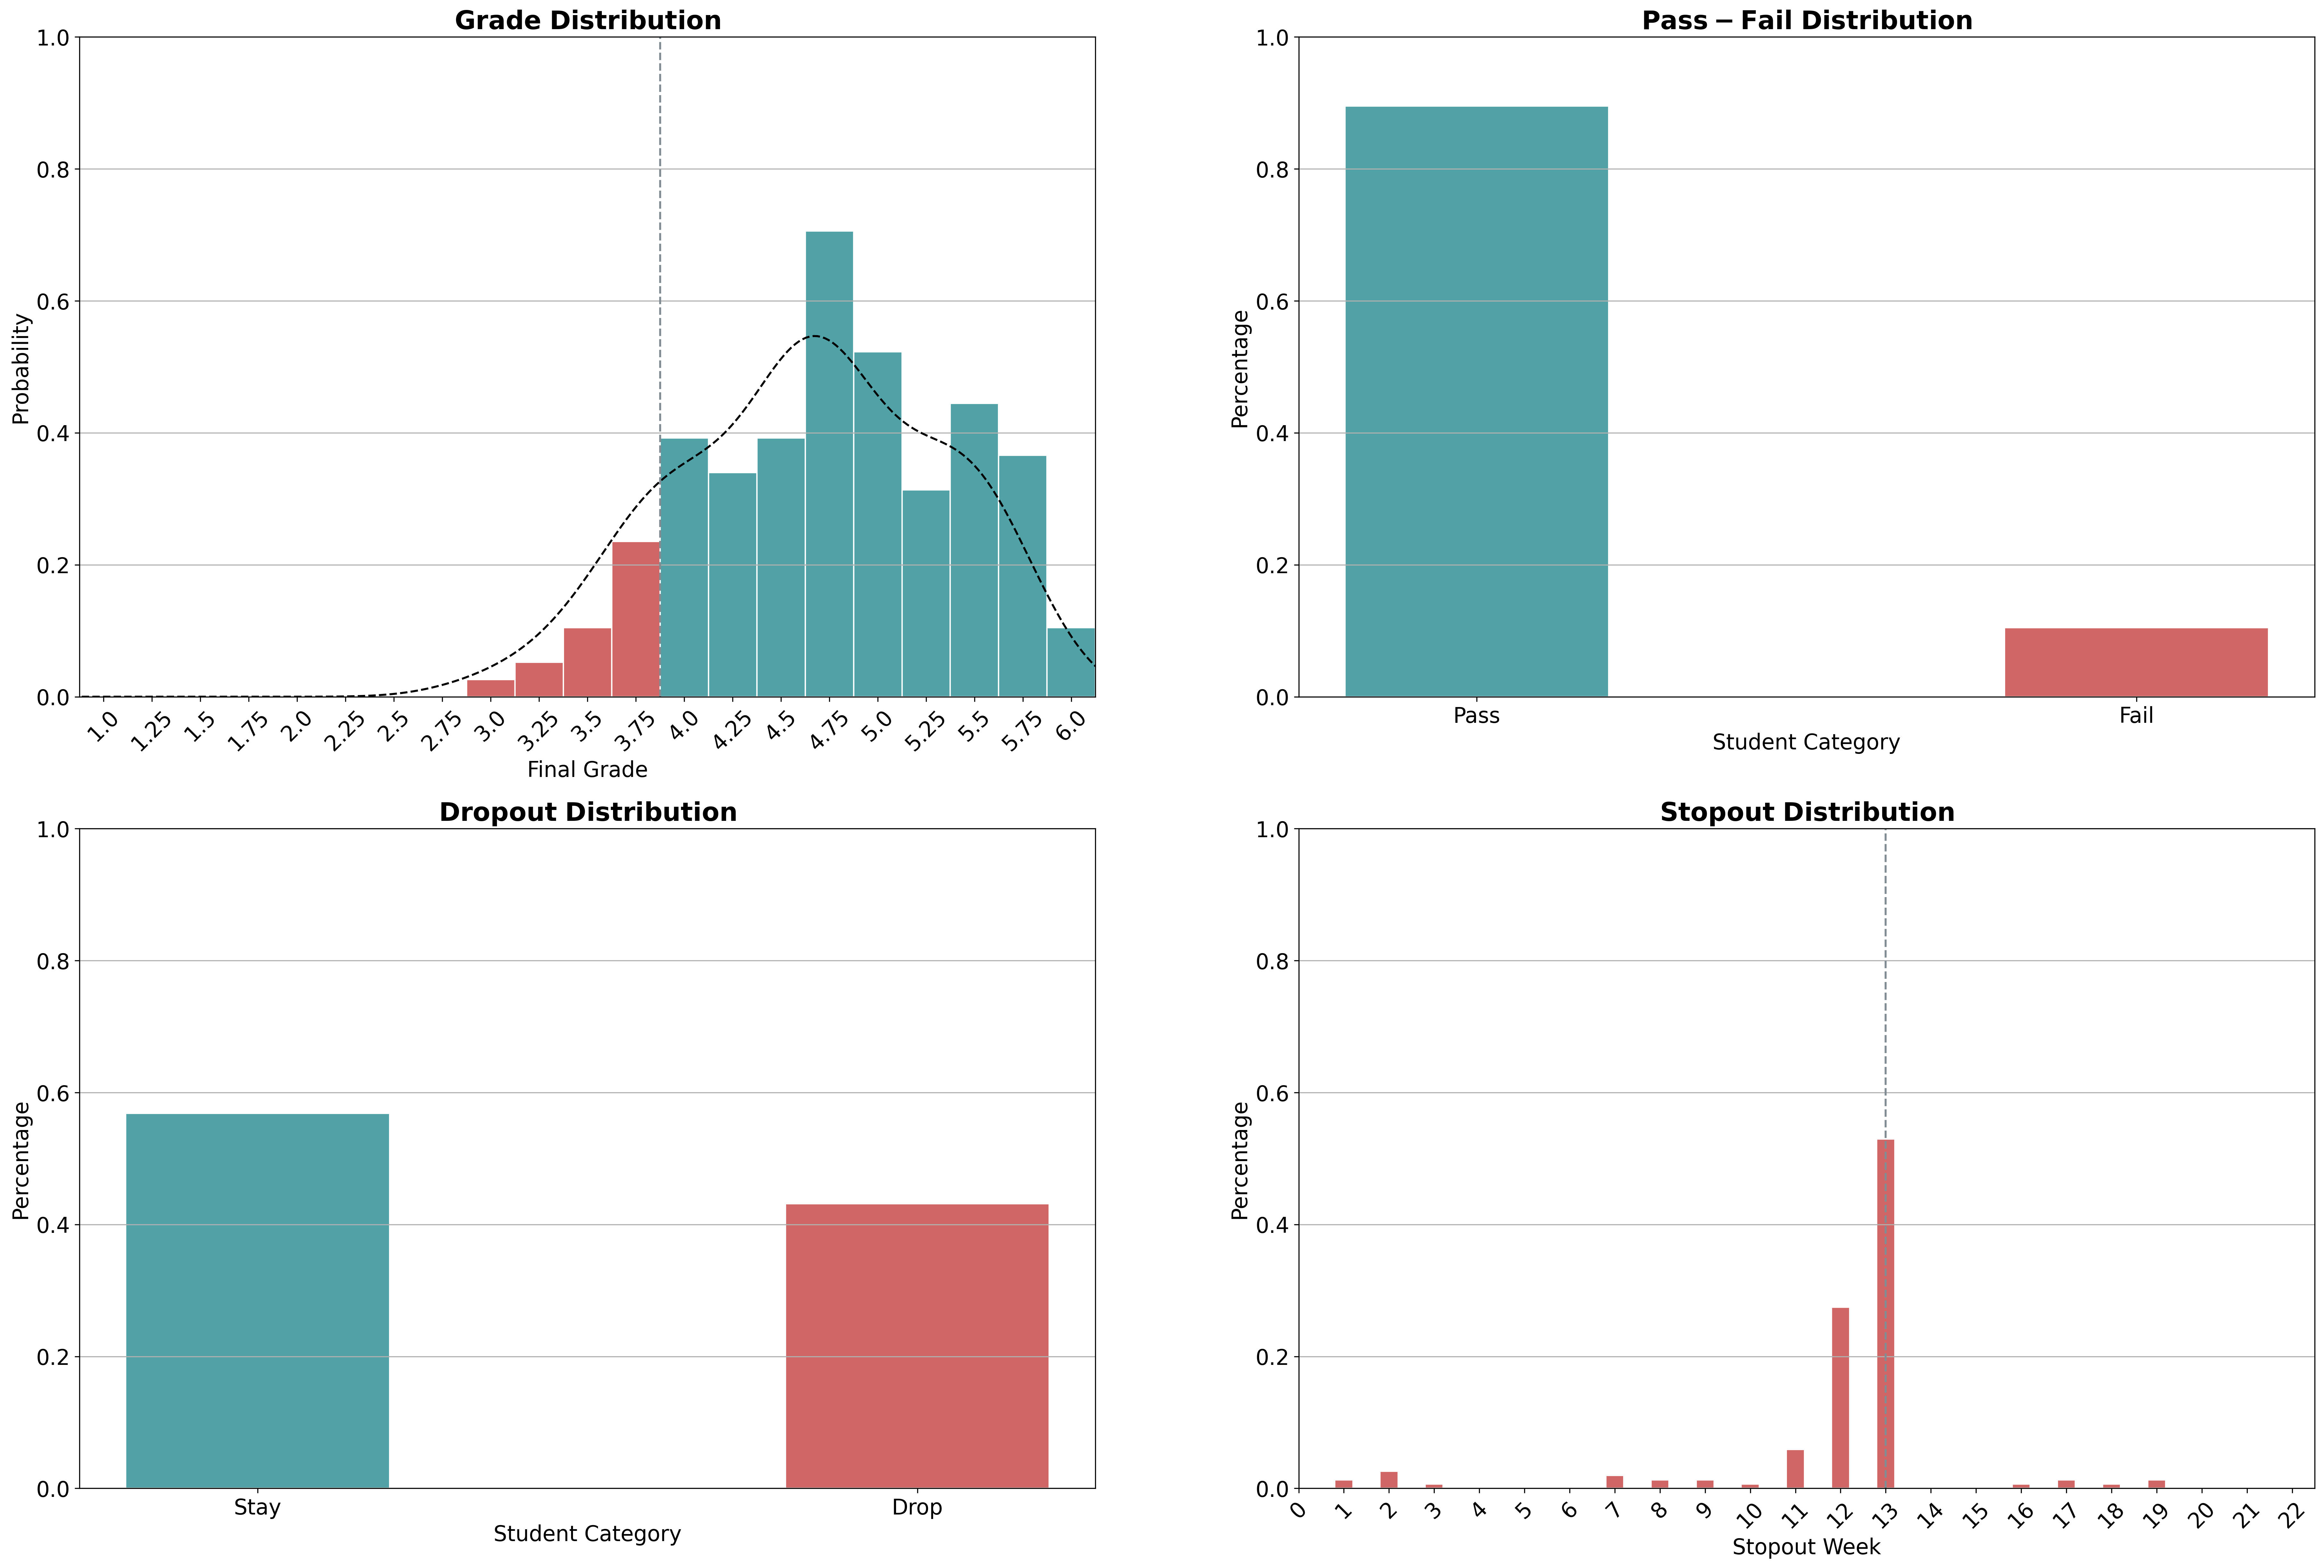

In [56]:
plt.figure(figsize=(30, 20), dpi=300)
plt.rcParams.update({'font.size': 16})

plt.subplot(2, 2, 1)
plot_grade_distribution(course, mingrade=1, maxgrade=6, depgrade=.25, thrgrade=4.0)

plt.subplot(2, 2, 2)
plot_pass_fail_distribution(course)

plt.subplot(2, 2, 3)
plot_dropout_distribution(course)

plt.subplot(2, 2, 4)
plot_stopout_distribution(course)

#### Feature Exploration

In [529]:
# Data
weeks = np.arange(course_data['Weeks'])
users = course_data['Outcomes']['AccountUserID'].values

our_feature_set = np.zeros((len(users), len(weeks), 13))

for wid, week in tqdm(enumerate(weeks)):
    
    for uid, user in enumerate(users):
    
        user_data = course_data['Clickstream'][course_data['Clickstream']['AccountUserID'] == user]
        user_data_weekly = user_data[user_data['Week'] == week]
        user_weekly_problems = user_data[(user_data['Week'] == week) & (user_data['EventType'].str.contains('Problem.'))]
        user_weekly_videos = user_data[(user_data['Week'] == week) & (user_data['EventType'].str.contains('Video.'))]
        bef_user_weekly_problems = user_data[(user_data['Week'] <= week) & (user_data['EventType'].str.contains('Problem.'))]
        bef_user_weekly_videos = user_data[(user_data['Week'] <= week) & (user_data['EventType'].str.contains('Video.'))]
        aft_user_weekly_problems = user_data[(user_data['Week'] > week) & (user_data['EventType'].str.contains('Problem.'))]
        aft_user_weekly_videos = user_data[(user_data['Week'] > week) & (user_data['EventType'].str.contains('Video.'))]
        
        if len(user_weekly_problems) > 0:
            dfmax = user_weekly_problems.groupby(by='ProblemID').max()
            nsub = dfmax['SubmissionNumber'].values
            ngra = dfmax['Grade'].values / 100.0
            our_feature_set[uid, wid, 0] = np.mean((1 / nsub) * ngra)
            
        if len(user_weekly_problems) > 0:
            pweek = problem_schedule[problem_schedule['Week'] == week]['ProblemID'].unique()
            puweek = user_weekly_problems['ProblemID'].unique()
            our_feature_set[uid, wid, 1] = len(set(pweek) & set(puweek)) / len(pweek) if len(pweek) > 0 else 0
            
        pweek = problem_schedule[problem_schedule['Week'] <= week]['ProblemID'].unique()
        puweek = bef_user_weekly_problems['ProblemID'].unique()
        our_feature_set[uid, wid, 2] = len(set(pweek) & set(puweek)) / len(pweek) if len(pweek) > 0 else 0
        
        pweek = problem_schedule[problem_schedule['Week'] > week]['ProblemID'].unique()
        puweek = bef_user_weekly_problems['ProblemID'].unique()
        our_feature_set[uid, wid, 3] = len(set(pweek) & set(puweek)) / len(pweek) if len(pweek) > 0 else 0
            
        if len(user_weekly_videos) > 0:
            pweek = video_schedule[video_schedule['Week'] == week]['VideoID'].unique()
            puweek = user_weekly_videos['VideoID'].unique()
            our_feature_set[uid, wid, 4] = len(set(pweek) & set(puweek)) / len(pweek) if len(pweek) > 0 else 0
            
        pweek = video_schedule[video_schedule['Week'] <= week]['VideoID'].unique()
        puweek = bef_user_weekly_videos['VideoID'].unique()
        our_feature_set[uid, wid, 5] = len(set(pweek) & set(puweek)) / len(pweek) if len(pweek) > 0 else 0
        
        pweek = video_schedule[video_schedule['Week'] > week]['VideoID'].unique()
        puweek = bef_user_weekly_videos['VideoID'].unique()
        our_feature_set[uid, wid, 6] = len(set(pweek) & set(puweek)) / len(pweek) if len(pweek) > 0 else 0
        
        if len(user_weekly_problems) > 10:
            d = user_weekly_problems.sort_values(by='Date')['Date'].diff().dt.total_seconds()[1:].sort_values()
            d = d[(d > np.percentile(d, 10)) & (d < np.percentile(d, 90))].values
            c = (d - np.min(d)) / (np.max(d) - np.min(d))
            our_feature_set[uid, wid, 7] = np.std(c)
            
        if len(user_weekly_problems) > 0:
            list1 = user_weekly_problems.drop_duplicates(subset=['ProblemID'], keep='first')['Grade'].values
            count_dups = np.array([sum(1 for _ in group) for _, group in groupby(list1)]) 
            unique_dup = np.array([x[0] for x in groupby(list1)]) / 100.
            pos_ok = np.where(unique_dup > 0)[0]
            probs = count_dups / np.sum(count_dups)
            our_feature_set[uid, wid, 8] = np.sum(probs[pos_ok])
        
        if len(user_weekly_videos) > 2:
            puweek = user_weekly_videos['VideoID'].unique()
            user_weekly_videos['PrevEvent'] = user_weekly_videos['EventType'].shift(1)
            user_weekly_videos['PrevVideo'] = user_weekly_videos['VideoID'].shift(1)
            w = user_weekly_videos.copy()
            s = w[(w['PrevEvent'] == 'Video.Play') & (w['EventType'] == 'Video.Stop') & (w['PrevVideo'] == w['VideoID'])]
            our_feature_set[uid, wid, 9] = np.sum(len(s) / len(puweek))
            
        w = user_weekly_videos[user_weekly_videos['EventType'].isin(['Video.Play', 'Video.Pause'])].copy()
        w['PrevEvent'] = w['EventType'].shift(1)
        w['PrevVideo'] = w['VideoID'].shift(1)
        w['PrevTime'] = w['Date'].shift(1)
        w = w[(w['PrevEvent'] == 'Video.Pause') & (w['EventType'] == 'Video.Play') & (w['PrevVideo'] == w['VideoID'])]
        w['TimeDiff'] = (w['Date'] - w['PrevTime']).dt.total_seconds()
        if np.nansum(w['TimeDiff'].values)  > 0:
            our_feature_set[uid, wid, 10] = 1 - 1 / np.nansum(w['TimeDiff'].values) 
        
        if len(user_data_weekly) > 0:
            our_feature_set[uid, wid, 11] = len(user_data_weekly['Weekday'].unique()) / 7.0
        
        if len(user_data_weekly) > 10:
            d = user_data_weekly.sort_values(by='Date')['Date'].diff().dt.total_seconds()[1:].sort_values()
            d = d[d < 60*20].values
            our_feature_set[uid, wid, 12] = 1 - 1 / np.sum(d)

16it [02:34,  9.63s/it]


In [530]:
# Labels
pass_ix = course_data['Outcomes'][course_data['Outcomes']['Pass-Fail'] == 0].index 
fail_ix = course_data['Outcomes'][course_data['Outcomes']['Pass-Fail'] == 1].index 

# Figure
plt.figure(figsize=(30, 64), dpi=300)
plt.rcParams.update({'font.size': 16})

plt.subplot(7, 2, 1)
plt.plot(weeks, np.mean(our_feature_set[pass_ix, :, 0], axis=0), label='Pass', color='#50A2A7')
plt.plot(weeks, np.mean(our_feature_set[fail_ix, :, 0], axis=0), label='Fail', color='#D16666')

plt.title('Competency Strength')
plt.ylabel('Competency Strength')
plt.xlabel('Week')
plt.ylim([0, 1])
plt.xlim(0, len(weeks) - 1)
plt.grid()
plt.legend()

plt.subplot(7, 2, 2)
plt.plot(weeks, np.mean(our_feature_set[pass_ix, :, 1], axis=0), label='Pass', color='#50A2A7')
plt.plot(weeks, np.mean(our_feature_set[fail_ix, :, 1], axis=0), label='Fail', color='#D16666')

plt.title('Competency Alignment')
plt.ylabel('Competency Alignment')
plt.xlabel('Week')
plt.ylim([0, 1])
plt.xlim(0, len(weeks) - 1)
plt.grid()
plt.legend()

plt.subplot(7, 2, 3)
plt.plot(weeks, np.mean(our_feature_set[pass_ix, :, 2], axis=0), label='Pass', color='#50A2A7')
plt.plot(weeks, np.mean(our_feature_set[fail_ix, :, 2], axis=0), label='Fail', color='#D16666')

plt.title('Competency Coverage')
plt.ylabel('Competency Coverage')
plt.xlabel('Week')
plt.ylim([0, 1])
plt.xlim(0, len(weeks) - 1)
plt.grid()
plt.legend()

plt.subplot(7, 2, 4)
plt.plot(weeks, np.mean(our_feature_set[pass_ix, :, 3], axis=0), label='Pass', color='#50A2A7')
plt.plot(weeks, np.mean(our_feature_set[fail_ix, :, 3], axis=0), label='Fail', color='#D16666')

plt.title('Competency Anticipation')
plt.ylabel('Competency Anticipation')
plt.xlabel('Week')
plt.ylim([0, 1])
plt.xlim(0, len(weeks) - 1)
plt.grid()
plt.legend()

plt.subplot(7, 2, 5)
plt.plot(weeks, np.mean(our_feature_set[pass_ix, :, 4], axis=0), label='Pass', color='#50A2A7')
plt.plot(weeks, np.mean(our_feature_set[fail_ix, :, 4], axis=0), label='Fail', color='#D16666')

plt.title('Content Alignment')
plt.ylabel('Content Alignment')
plt.xlabel('Week')
plt.ylim([0, 1])
plt.xlim(0, len(weeks) - 1)
plt.grid()
plt.legend()

plt.subplot(7, 2, 6)
plt.plot(weeks, np.mean(our_feature_set[pass_ix, :, 5], axis=0), label='Pass', color='#50A2A7')
plt.plot(weeks, np.mean(our_feature_set[fail_ix, :, 5], axis=0), label='Fail', color='#D16666')

plt.title('Content Coverage')
plt.ylabel('Content Coverage')
plt.xlabel('Week')
plt.ylim([0, 1])
plt.xlim(0, len(weeks) - 1)
plt.grid()
plt.legend()

plt.subplot(7, 2, 7)
plt.plot(weeks, np.mean(our_feature_set[pass_ix, :, 6], axis=0), label='Pass', color='#50A2A7')
plt.plot(weeks, np.mean(our_feature_set[fail_ix, :, 6], axis=0), label='Fail', color='#D16666')

plt.title('Content Anticipation')
plt.ylabel('Content Anticipation')
plt.xlabel('Week')
plt.ylim([0, 1])
plt.xlim(0, len(weeks) - 1)
plt.grid()
plt.legend()

plt.subplot(7, 2, 8)
plt.plot(weeks, np.mean(our_feature_set[pass_ix, :, 7], axis=0), label='Pass', color='#50A2A7')
plt.plot(weeks, np.mean(our_feature_set[fail_ix, :, 7], axis=0), label='Fail', color='#D16666')

plt.title('Student Interaction Speed')
plt.ylabel('Student Interaction Speed')
plt.xlabel('Week')
plt.ylim([0, 1])
plt.xlim(0, len(weeks) - 1)
plt.grid()
plt.legend()

plt.subplot(7, 2, 9)
plt.plot(weeks, np.mean(our_feature_set[pass_ix, :, 8], axis=0), label='Pass', color='#50A2A7')
plt.plot(weeks, np.mean(our_feature_set[fail_ix, :, 8], axis=0), label='Fail', color='#D16666')

plt.title('Student Shape')
plt.ylabel('Student Shape')
plt.xlabel('Week')
plt.ylim([0, 1])
plt.xlim(0, len(weeks) - 1)
plt.grid()
plt.legend()

plt.subplot(7, 2, 10)
plt.plot(weeks, np.mean(our_feature_set[pass_ix, :, 9], axis=0), label='Pass', color='#50A2A7')
plt.plot(weeks, np.mean(our_feature_set[fail_ix, :, 9], axis=0), label='Fail', color='#D16666')

plt.title('Student Activeness')
plt.ylabel('Student Activeness')
plt.xlabel('Week')
plt.ylim([0, 1])
plt.xlim(0, len(weeks) - 1)
plt.grid()
plt.legend()

plt.subplot(7, 2, 11)
plt.plot(weeks, np.mean(our_feature_set[pass_ix, :, 10], axis=0), label='Pass', color='#50A2A7')
plt.plot(weeks, np.mean(our_feature_set[fail_ix, :, 10], axis=0), label='Fail', color='#D16666')

plt.title('Student Thoughtfulness')
plt.ylabel('Student Thoughtfulness')
plt.xlabel('Week')
plt.ylim([0, 1])
plt.xlim(0, len(weeks) - 1)
plt.grid()
plt.legend()

plt.subplot(7, 2, 12)
plt.plot(weeks, np.mean(our_feature_set[pass_ix, :, 11], axis=0), label='Pass', color='#50A2A7')
plt.plot(weeks, np.mean(our_feature_set[fail_ix, :, 11], axis=0), label='Fail', color='#D16666')

plt.title('Student Weekly Day Activeness')
plt.ylabel('Student Weekly Day Activeness')
plt.xlabel('Week')
plt.ylim([0, 1])
plt.xlim(0, len(weeks) - 1)
plt.grid()
plt.legend()

plt.subplot(7, 2, 13)
plt.plot(weeks, np.mean(our_feature_set[pass_ix, :, 12], axis=0), label='Pass', color='#50A2A7')
plt.plot(weeks, np.mean(our_feature_set[fail_ix, :, 12], axis=0), label='Fail', color='#D16666')

plt.title('Student Weekly Time')
plt.ylabel('Student Weekly Time')
plt.xlabel('Week')
plt.ylim([0, 1])
plt.xlim(0, len(weeks) - 1)
plt.grid()
plt.legend()

plt.show()

#### Raw Sequence Exploration

In [346]:
maps = {a:i+1 for i, a in enumerate(params['video_events'] + params['problem_events'])}
print('Integer-encoder Events:', maps, sep='\n')

Integer-encoder Events:
{'Video.Pause': 1, 'Video.Load': 2, 'Video.Play': 3, 'Video.Seek': 4, 'Video.Stop': 5, 'Video.SpeedChange': 6, 'Problem.Check': 7}


In [347]:
nsequence = 300

acts = np.zeros((len(users), len(weeks), nsequence))
tims = np.zeros((len(users), len(weeks), nsequence))

for sid, user_id in tqdm(enumerate(users)):
    data = course_data['Clickstream'][course_data['Clickstream']['AccountUserID'] == user_id].sort_values(by='Date').copy()
    data['EventTypeID'] = data['EventType'].apply(lambda x: maps[x])
    for wid in weeks:
        data_week = data[data['Week'] == wid]
        if len(data_week) > 0:
            acts[sid, wid] = data_week['EventTypeID'].values[:nsequence] if len(data_week) > nsequence else np.pad(data_week['EventTypeID'].values, (0, nsequence-len(data_week)), 'constant')
            tims[sid, wid] = data_week['TimeStamp'].values[:nsequence] if len(data_week) > nsequence else np.pad(data_week['TimeStamp'].values, (0, nsequence-len(data_week)), 'constant')

214it [00:03, 54.25it/s]


## ** Model Build and Evaluation **

#### Attention Layer

In [314]:
class Attention(tf.keras.layers.Layer):
    def __init__(self, W_regularizer=None, b_regularizer=None, W_constraint=None, b_constraint=None, bias=True, return_attention=False, **kwargs):
    
        self.supports_masking = True
        self.return_attention = return_attention
        self.init = tf.keras.initializers.get('glorot_uniform')

        self.W_regularizer = tf.keras.regularizers.get(W_regularizer)
        self.b_regularizer = tf.keras.regularizers.get(b_regularizer)

        self.W_constraint = tf.keras.constraints.get(W_constraint)
        self.b_constraint = tf.keras.constraints.get(b_constraint)

        self.bias = bias
        super(Attention, self).__init__(**kwargs)

    def build(self, input_shape):
        assert len(input_shape) == 3

        self.W = self.add_weight(shape=(input_shape[-1],), initializer=self.init, name='{}_W'.format(self.name), regularizer=self.W_regularizer, constraint=self.W_constraint)
        if self.bias:
            self.b = self.add_weight(shape=(input_shape[1],), initializer='zero', name='{}_b'.format(self.name), regularizer=self.b_regularizer, constraint=self.b_constraint)
        else:
            self.b = None

        self.built = True

    def compute_mask(self, input, input_mask=None):
        return None

    def call(self, x, mask=None):
        eij = tf.keras.backend.squeeze(tf.keras.backend.dot(x, tf.keras.backend.expand_dims(self.W)), axis=-1) 

        if self.bias:
            eij += self.b

        eij = tf.keras.backend.tanh(eij)

        a = tf.keras.backend.exp(eij)
        
        if mask is not None:
            a *= tf.keras.backend.cast(mask, tf.keras.backend.floatx())

        a /= tf.keras.backend.cast(tf.keras.backend.sum(a, axis=1, keepdims=True) + tf.keras.backend.epsilon(), tf.keras.backend.floatx())

        weighted_input = x * tf.keras.backend.expand_dims(a)

        result = tf.keras.backend.sum(weighted_input, axis=1)

        if self.return_attention:
            return [result, a]
        return result

    def compute_output_shape(self, input_shape):
        if self.return_attention:
            return [(input_shape[0], input_shape[-1]),
                    (input_shape[0], input_shape[1])]
        else:
            return input_shape[0], input_shape[-1]

#### Classifier with Features

In [479]:
def create_encoder(nweeks, nfeatures):
    inp = tf.keras.layers.Input(shape=(nweeks, nfeatures,))
    x = tf.keras.layers.LSTM(hidden_units, return_sequences=True, implementation=1)(inp)
    x = Attention()(x)
    return tf.keras.models.Model(inputs=[inp], outputs=[x])

def create_classifier(encoder, trainable=True):

    for layer in encoder.layers:
        layer.trainable = trainable
        
    inp = tf.keras.Input(shape=encoder.input_shape[1:])
    x = tf.keras.layers.Dense(1, activation='sigmoid')(encoder(inp))
    model = tf.keras.Model(inputs=[inp], outputs=[x])
    
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate), loss='binary_crossentropy', metrics='binary_accuracy')
    
    return model

class SupervisedContrastiveLoss(tf.keras.losses.Loss):
    def __init__(self, temperature=1, name=None):
        super(SupervisedContrastiveLoss, self).__init__(name=name)
        self.temperature = temperature

    def __call__(self, labels, feature_vectors, sample_weight=None):
        feature_vectors_normalized = tf.math.l2_normalize(feature_vectors, axis=1)
        logits = tf.divide(tf.matmul(feature_vectors_normalized, tf.transpose(feature_vectors_normalized)), self.temperature,)
        return tfa.losses.npairs_loss(tf.squeeze(labels), logits)

def add_projection_head(encoder):
    inputs = tf.keras.layers.Input(shape=encoder.input_shape[1:])
    features = encoder(inputs)
    outputs = tf.keras.layers.Dense(projection_units, activation='relu')(features)
    outputs = tf.keras.layers.Dense(projection_units // 2, activation='relu')(outputs)
    model = tf.keras.Model(inputs=inputs, outputs=outputs, name='encoder_with_projection-head')
    return model

In [537]:
# Paramaters
num_epochs = 400
batch_size = 32
learning_rate = 0.01

projection_units = 64
hidden_units = 64
temperature = .4

nweeks = 4
nfeatures = 13
class_weight = {0:1, 1:2.5}

# Early stopping
early_stopping_clf = tf.keras.callbacks.EarlyStopping(monitor='binary_accuracy', verbose=0, patience=50, min_delta=0.1, mode='max', restore_best_weights=True)
early_stopping_enc = tf.keras.callbacks.EarlyStopping(monitor='loss', verbose=0, patience=50, mode='min', restore_best_weights=True)

# Data Ingestion
X = our_feature_set[:, :nweeks, :nfeatures]
y = course_data['Outcomes']['Pass-Fail'].values

nfolds = 10

evals = {}
for model in ['DM', 'RF', 'SVM', 'O1', 'O2']:
    evals[model] = {} 
    evals[model]['B-Acc'] = np.zeros(nfolds)
    evals[model]['R-Fail'] = np.zeros(nfolds)
    evals[model]['R-Pass'] = np.zeros(nfolds)
    evals[model]['AUC'] = np.zeros(nfolds)
    evals[model]['F1'] = np.zeros(nfolds)

misclassified = {}

# Hold-out Validation
kf = StratifiedKFold(n_splits=nfolds)
for fold, (train_index, test_index) in tqdm(enumerate(kf.split(X, y))):
    
    # Data Split
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    pass_ix = np.where(y_test==0)[0]
    fail_ix = np.where(y_test==1)[0]
    pass_ix_train = np.where(y_train==0)[0]
    fail_ix_train = np.where(y_train==1)[0]
    
    # Dataset balancing
    while len(pass_ix_train) > len(fail_ix_train):
        sids = np.random.choice(fail_ix_train, size=np.random.randint(2, 25))
        stud = np.expand_dims(np.mean(X_train[sids], axis=0), axis=0)
        X_train = np.append(X_train, stud, axis=0)
        y_train = np.append(y_train, [1], axis=0)
        pass_ix_train = np.where(y_train==0)[0]
        fail_ix_train = np.where(y_train==1)[0]
    
    # Baseline classifiers
    
    # - DNN
    encoder = create_encoder(nweeks, nfeatures)
    classifier = create_classifier(encoder)
    classifier.fit(x=X_train, y=y_train, batch_size=batch_size, epochs=num_epochs, class_weight=class_weight, shuffle=True, callbacks=[early_stopping_clf], verbose=0)   
    y_pred_prob = classifier.predict(X_test, batch_size=batch_size).flatten()
    y_pred = np.round(y_pred_prob)
    evals['O1']['B-Acc'][fold] = balanced_accuracy_score(y_test, y_pred)
    evals['O1']['R-Fail'][fold] = balanced_accuracy_score(y_test[fail_ix], y_pred[fail_ix])
    evals['O1']['R-Pass'][fold] = balanced_accuracy_score(y_test[pass_ix], y_pred[pass_ix])
    evals['O1']['F1'][fold] = f1_score(y_test, y_pred)
    fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred, pos_label=1)
    evals['O1']['AUC'][fold] = metrics.auc(fpr, tpr)
   
    if 'O1' not in misclassified:
        misclassified['O1'] = {}
    for i, (t, p) in enumerate(zip(y_test, y_pred_prob)):
        user_id = users[test_index[i]]
        if t != tf.round(p).numpy():
            misclassified['O1'][user_id] = {}
            misclassified['O1'][user_id]['True'] = t
            misclassified['O1'][user_id]['Prob'] = p
            misclassified['O1'][user_id]['Pred'] = tf.round(p).numpy()

    # - Dummy
    dummy_clf = DummyClassifier(strategy='stratified')
    dummy_clf.fit(np.average(X_train, axis=1), y_train)
    y_pred = dummy_clf.predict(np.average(X_test, axis=1))
    evals['DM']['B-Acc'][fold] = balanced_accuracy_score(y_test, y_pred)
    evals['DM']['R-Fail'][fold] = balanced_accuracy_score(y_test[fail_ix], y_pred[fail_ix])
    evals['DM']['R-Pass'][fold] = balanced_accuracy_score(y_test[pass_ix], y_pred[pass_ix])
    evals['DM']['F1'][fold] = f1_score(y_test, y_pred)
    fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred, pos_label=1)
    evals['DM']['AUC'][fold] = metrics.auc(fpr, tpr)

    # - Random Forest
    rf_clf = RandomForestClassifier(n_estimators=100)
    rf_clf.fit(np.average(X_train, axis=1), y_train)
    y_pred = rf_clf.predict(np.average(X_test, axis=1))
    evals['RF']['B-Acc'][fold] = balanced_accuracy_score(y_test, y_pred)
    evals['RF']['R-Fail'][fold] = balanced_accuracy_score(y_test[fail_ix], y_pred[fail_ix])
    evals['RF']['R-Pass'][fold] = balanced_accuracy_score(y_test[pass_ix], y_pred[pass_ix])
    evals['RF']['F1'][fold] = f1_score(y_test, y_pred)
    fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred, pos_label=1)
    evals['RF']['AUC'][fold] = metrics.auc(fpr, tpr)
    
    # - SVM
    svm_clf = SVC()
    svm_clf.fit(np.average(X_train, axis=1), y_train)
    y_pred = svm_clf.predict(np.average(X_test, axis=1))
    evals['SVM']['B-Acc'][fold] = balanced_accuracy_score(y_test, y_pred)
    evals['SVM']['R-Fail'][fold] = balanced_accuracy_score(y_test[fail_ix], y_pred[fail_ix])
    evals['SVM']['R-Pass'][fold] = balanced_accuracy_score(y_test[pass_ix], y_pred[pass_ix])
    evals['SVM']['F1'][fold] = f1_score(y_test, y_pred)
    fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred, pos_label=1)
    evals['SVM']['AUC'][fold] = metrics.auc(fpr, tpr)
  
    # Our Proposal 
    encoder = create_encoder(nweeks, nfeatures)
    encoder_with_projection_head = add_projection_head(encoder)
    encoder_with_projection_head.compile(optimizer=tf.keras.optimizers.Adam(learning_rate), loss=SupervisedContrastiveLoss(temperature))
    encoder_with_projection_head.fit(x=X_train, y=y_train, batch_size=batch_size, epochs=num_epochs, shuffle=True, verbose=0)
    classifier = create_classifier(encoder, trainable=False)
    classifier.fit(x=X_train, y=y_train, batch_size=batch_size, epochs=num_epochs, shuffle=True, class_weight=class_weight, callbacks=[early_stopping_clf], verbose=0)
    y_pred = tf.round(classifier.predict(X_test, batch_size=batch_size)).numpy().flatten()
    evals['O2']['B-Acc'][fold] = balanced_accuracy_score(y_test, y_pred)
    evals['O2']['R-Fail'][fold] = balanced_accuracy_score(y_test[fail_ix], y_pred[fail_ix])
    evals['O2']['R-Pass'][fold] = balanced_accuracy_score(y_test[pass_ix], y_pred[pass_ix])
    evals['O2']['F1'][fold] = f1_score(y_test, y_pred)
    fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred, pos_label=1)
    evals['O2']['AUC'][fold] = metrics.auc(fpr, tpr)

10it [05:04, 30.43s/it]


In [532]:
lst = []
for model in evals.keys():
    a = np.nanmean(evals[model]['R-Pass'])
    b = np.nanmean(evals[model]['R-Fail'])
    c = np.nanmean(evals[model]['B-Acc'])
    d = np.nanmean(evals[model]['AUC'])
    e = np.nanmean(evals[model]['F1'])
    lst.append([model, a, b, c, d, e])
pd.DataFrame(lst, columns=['Model', 'R-Pass', 'R-Fail', 'B-Acc', 'AUC', 'F1'])

,Model,R-Pass,R-Fail,B-Acc,AUC,F1
0,DM,0.454396,0.5875,0.520948,0.520948,0.462366
1,RF,0.763736,0.5000,0.631868,0.631868,0.531181
2,SVM,0.756044,0.6125,0.684272,0.684272,0.603383
3,O1,0.725275,0.5625,0.643887,0.643887,0.540045
4,O2,0.719780,0.4875,0.603640,0.603640,0.497974


Reverse Engineering

In [533]:
misclassified['O1']

{12725: {'True': 0, 'Prob': 0.63878953, 'Pred': 1.0},
 13079: {'True': 1, 'Prob': 0.033290118, 'Pred': 0.0},
 12275: {'True': 1, 'Prob': 0.055681914, 'Pred': 0.0},
 11666: {'True': 1, 'Prob': 0.24223399, 'Pred': 0.0},
 48906: {'True': 1, 'Prob': 0.11830607, 'Pred': 0.0},
 11951: {'True': 0, 'Prob': 0.98725414, 'Pred': 1.0},
 12689: {'True': 0, 'Prob': 0.9965917, 'Pred': 1.0},
 51801: {'True': 0, 'Prob': 0.94236803, 'Pred': 1.0},
 11444: {'True': 0, 'Prob': 0.7304898, 'Pred': 1.0},
 46944: {'True': 1, 'Prob': 0.49588147, 'Pred': 0.0},
 49845: {'True': 1, 'Prob': 0.034394592, 'Pred': 0.0},
 46599: {'True': 1, 'Prob': 0.09297383, 'Pred': 0.0},
 46587: {'True': 1, 'Prob': 0.49573708, 'Pred': 0.0},
 44802: {'True': 0, 'Prob': 0.9384371, 'Pred': 1.0},
 44733: {'True': 0, 'Prob': 0.9966942, 'Pred': 1.0},
 46947: {'True': 0, 'Prob': 0.6278265, 'Pred': 1.0},
 47067: {'True': 0, 'Prob': 0.5462471, 'Pred': 1.0},
 49935: {'True': 1, 'Prob': 0.4223686, 'Pred': 0.0},
 51498: {'True': 1, 'Prob': 0.43

#### Classifier with Raw Sequences

In [371]:
def create_encoder(nweeks, nfeatures, max_acts=len(maps) + 1, embedding_dim=4):
    inp_1 = tf.keras.layers.Input(shape=(nweeks, nfeatures,))
    inp_2 = tf.keras.layers.Input(shape=(nweeks, nfeatures,))
    x_1 = tf.keras.layers.Embedding(max_acts, embedding_dim)(inp_1)
    x_2 = tf.keras.layers.Reshape(target_shape=(nweeks, nfeatures, 1,))(inp_2) 
    x = tf.keras.layers.Concatenate()([x_1, x_2])
    x = tf.keras.layers.Reshape(target_shape=(nweeks * nfeatures, embedding_dim + 1,))(x)
    x = tf.keras.layers.LSTM(hidden_units, return_sequences=False, implementation=1)(x)
    return tf.keras.models.Model(inputs=[inp_1, inp_2], outputs=[x])

def create_classifier(encoder, trainable=True):

    for layer in encoder.layers:
        layer.trainable = trainable
        
    inp_1 = tf.keras.Input(shape=encoder.inputs[0].shape[1:])
    inp_2 = tf.keras.Input(shape=encoder.inputs[1].shape[1:])
    x = tf.keras.layers.Dense(128, activation='relu')(encoder([inp_1, inp_2]))
    x = tf.keras.layers.Dense(64, activation='relu')(x)
    x = tf.keras.layers.Dense(32, activation='relu')(x)
    x = tf.keras.layers.Dense(1, activation='sigmoid')(x)
    model = tf.keras.Model(inputs=[inp_1, inp_2], outputs=[x])
    
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate), loss='binary_crossentropy', metrics='binary_accuracy')
    
    return model

class SupervisedContrastiveLoss(tf.keras.losses.Loss):
    def __init__(self, temperature=1, name=None):
        super(SupervisedContrastiveLoss, self).__init__(name=name)
        self.temperature = temperature

    def __call__(self, labels, feature_vectors, sample_weight=None):
        feature_vectors_normalized = tf.math.l2_normalize(feature_vectors, axis=1)
        logits = tf.divide(tf.matmul(feature_vectors_normalized, tf.transpose(feature_vectors_normalized)), self.temperature,)
        return tfa.losses.npairs_loss(tf.squeeze(labels), logits)

def add_projection_head(encoder):
    inputs = tf.keras.layers.Input(shape=encoder.input_shape[1:])
    features = encoder(inputs)
    outputs = tf.keras.layers.Dense(projection_units, activation='relu')(features)
    outputs = tf.keras.layers.Dense(projection_units // 2, activation='relu')(outputs)
    model = tf.keras.Model(inputs=inputs, outputs=outputs, name='encoder_with_projection-head')
    return model

In [ ]:
# Paramaters
num_epochs = 400
batch_size = 128
learning_rate = 0.01

projection_units = 64
hidden_units = 128
temperature = .4

# Early stopping
early_stopping_clf = tf.keras.callbacks.EarlyStopping(monitor='binary_accuracy', verbose=0, patience=50, min_delta=0.1, mode='max', restore_best_weights=True)
early_stopping_enc = tf.keras.callbacks.EarlyStopping(monitor='loss', verbose=0, patience=50, mode='min', restore_best_weights=True)

# Data Ingestion
X1 = acts 
X2 = tims 
y = course_data['Outcomes']['Pass-Fail'].values

nweeks = X1.shape[1]
nfeatures = X1.shape[2]
nfolds = 10

evals = {}
for model in ['O1', 'O2']:
    evals[model] = {} 
    evals[model]['B-Acc'] = np.zeros(nfolds)
    evals[model]['R-Fail'] = np.zeros(nfolds)
    evals[model]['R-Pass'] = np.zeros(nfolds)
    evals[model]['AUC'] = np.zeros(nfolds)
    evals[model]['F1'] = np.zeros(nfolds)

# Hold-out Validation
kf = StratifiedKFold(n_splits=nfolds)
for fold, (train_index, test_index) in tqdm(enumerate(kf.split(X, y))):
    
    # Data Split
    X1_train, X1_test = X1[train_index], X1[test_index]
    X2_train, X2_test = X2[train_index], X2[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    pass_ix = np.where(y_test==0)[0]
    fail_ix = np.where(y_test==1)[0]
    pass_ix_train = np.where(y_train==0)[0]
    fail_ix_train = np.where(y_train==1)[0]
    
    # Standardization
    scaler = StandardScaler()
    X2_train = np.reshape(scaler.fit_transform(np.reshape(X2_train, (X2_train.shape[0], nweeks*nfeatures))), (X2_train.shape[0], nweeks, nfeatures))
    X2_test = np.reshape(scaler.transform(np.reshape(X2_test, (X2_test.shape[0], nweeks*nfeatures))), (X2_test.shape[0], nweeks, nfeatures))
    
    # Baseline classifiers
    
    # - DNN
    encoder = create_encoder(nweeks, nfeatures)
    classifier = create_classifier(encoder)
    classifier.fit(x=[X1_train, X2_train], y=y_train, batch_size=batch_size, epochs=num_epochs, shuffle=True, callbacks=[early_stopping_clf], verbose=1)   
    y_pred = tf.round(classifier.predict([X1_test, X2_test], batch_size=batch_size)).numpy().flatten()
    evals['O1']['B-Acc'][fold] = balanced_accuracy_score(y_test, y_pred)
    evals['O1']['R-Fail'][fold] = balanced_accuracy_score(y_test[fail_ix], y_pred[fail_ix])
    evals['O1']['R-Pass'][fold] = balanced_accuracy_score(y_test[pass_ix], y_pred[pass_ix])
    evals['O1']['F1'][fold] = f1_score(y_test, y_pred)
    fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred, pos_label=1)
    evals['O1']['AUC'][fold] = metrics.auc(fpr, tpr)
  
    # Our Proposal 
    encoder = create_encoder(nweeks, nfeatures)
    encoder_with_projection_head = add_projection_head(encoder)
    encoder_with_projection_head.compile(optimizer=tf.keras.optimizers.Adam(learning_rate), loss=SupervisedContrastiveLoss(temperature))
    encoder_with_projection_head.fit(x=[X1_train, X2_train], y=y_train, batch_size=batch_size, epochs=num_epochs, shuffle=True, verbose=0)
    classifier = create_classifier(encoder, trainable=False)
    classifier.fit(x=X_train, y=y_train, batch_size=batch_size, epochs=num_epochs, shuffle=True, callbacks=[early_stopping_clf], verbose=0)
    y_pred = tf.round(classifier.predict([X1_test, X2_test], batch_size=batch_size)).numpy().flatten()
    evals['O2']['B-Acc'][fold] = balanced_accuracy_score(y_test, y_pred)
    evals['O2']['R-Fail'][fold] = balanced_accuracy_score(y_test[fail_ix], y_pred[fail_ix])
    evals['O2']['R-Pass'][fold] = balanced_accuracy_score(y_test[pass_ix], y_pred[pass_ix])
    evals['O2']['F1'][fold] = f1_score(y_test, y_pred)
    fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred, pos_label=1)
    evals['O2']['AUC'][fold] = metrics.auc(fpr, tpr)

In [ ]:
lst = []
for model in evals.keys():
    a = np.nanmean(evals[model]['R-Pass'])
    b = np.nanmean(evals[model]['R-Fail'])
    c = np.nanmean(evals[model]['B-Acc'])
    d = np.nanmean(evals[model]['AUC'])
    e = np.nanmean(evals[model]['F1'])
    lst.append([model, a, b, c, d, e])
pd.DataFrame(lst, columns=['Model', 'R-Pass', 'R-Fail', 'B-Acc', 'AUC', 'F1'])

#### Classifier with Autoencoders

In [374]:
from models.ae.model import variational_simple, direct_simple, variational, direct, l1norm, corr
from models.ae.model import vae_conv2lstm_1D, vae_conv2lstm
from models.ae.model import vae_d2lstm, vae_d2lstm_1D

In [473]:
config = {
    'batch_size': 32,
    'holdout_size': 1000,
    'n_epochs': 12,
    'latent_dim': 32,
    'inner_dim': 80,
    'output_dim': 10,
    'n_layers': 1,
    'n_dense': 3,
    'beta': 0.5,
    'learning_rate_decay': 0.000,
    'learning_rate': 0.001,
    'activation': 'relu',
    'dropout': 0.25,
    'weight_initialization': 'he_normal',
    'reduce_lr': False,
    'obs_per_timestep': 11,
    'n_features': 44,
    'conv_filter_n': 64
}

In [474]:
def create_classifier(latent_dim):

    inp = tf.keras.layers.Input(shape=(latent_dim,))
    x = tf.keras.layers.Dense(32, activation='relu')(inp)
    x = tf.keras.layers.Dense(16, activation='relu')(x)
    x = tf.keras.layers.Dense(1, activation='sigmoid')(x)
    model = tf.keras.Model(inputs=[inp], outputs=[x])
    
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate), loss='binary_crossentropy', metrics='binary_accuracy')
    
    return model

In [475]:
nweeks = 4
nfeatures = 11
X_f = our_feature_set[:, :nweeks, :nfeatures].copy()
ae_model, ae, latent_statistics, sampler, _ = vae_d2lstm(config)
history = ae_model.fit(X_f, X_f, batch_size=config['batch_size'], epochs=config['n_epochs'], shuffle=True, verbose=0)

In [476]:
# Paramaters
num_epochs = 400
batch_size = 32
learning_rate = 0.01
hidden_units = 64

# Early stopping
early_stopping_clf = tf.keras.callbacks.EarlyStopping(monitor='binary_accuracy', verbose=0, patience=50, min_delta=0.1, mode='max', restore_best_weights=True)

# Data Ingestion
X = ae(X_f).numpy()
y = course_data['Outcomes']['Pass-Fail'].values

nfolds = 15

evals = {}
for model in ['DM', 'RF', 'O1']:
    evals[model] = {} 
    evals[model]['B-Acc'] = np.zeros(nfolds)
    evals[model]['R-Fail'] = np.zeros(nfolds)
    evals[model]['R-Pass'] = np.zeros(nfolds)
    evals[model]['AUC'] = np.zeros(nfolds)
    evals[model]['F1'] = np.zeros(nfolds)

# Hold-out Validation
kf = StratifiedKFold(n_splits=nfolds)
for fold, (train_index, test_index) in tqdm(enumerate(kf.split(X, y))):
    
    # Data Split
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    pass_ix = np.where(y_test==0)[0]
    fail_ix = np.where(y_test==1)[0]
    pass_ix_train = np.where(y_train==0)[0]
    fail_ix_train = np.where(y_train==1)[0]
    
    # Dataset balancing
    while len(pass_ix_train) > len(fail_ix_train):
        sids = np.random.choice(fail_ix_train, size=np.random.randint(10, 25))
        stud = np.expand_dims(np.mean(X_train[sids], axis=0), axis=0)
        X_train = np.append(X_train, stud, axis=0)
        y_train = np.append(y_train, [1], axis=0)
        pass_ix_train = np.where(y_train==0)[0]
        fail_ix_train = np.where(y_train==1)[0]
    
    # Baseline classifiers
    
    # - DNN
    classifier = create_classifier(config['latent_dim'])
    classifier.fit(x=X_train, y=y_train, batch_size=batch_size, epochs=num_epochs, shuffle=True, callbacks=[early_stopping_clf], verbose=0)   
    y_pred = tf.round(classifier.predict(X_test, batch_size=batch_size)).numpy().flatten()
    evals['O1']['B-Acc'][fold] = balanced_accuracy_score(y_test, y_pred)
    evals['O1']['R-Fail'][fold] = balanced_accuracy_score(y_test[fail_ix], y_pred[fail_ix])
    evals['O1']['R-Pass'][fold] = balanced_accuracy_score(y_test[pass_ix], y_pred[pass_ix])
    evals['O1']['F1'][fold] = f1_score(y_test, y_pred)
    fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred, pos_label=1)
    evals['O1']['AUC'][fold] = metrics.auc(fpr, tpr)
   
    # - Dummy
    dummy_clf = DummyClassifier(strategy='stratified')
    dummy_clf.fit(X_train, y_train)
    y_pred = dummy_clf.predict(X_test)
    evals['DM']['B-Acc'][fold] = balanced_accuracy_score(y_test, y_pred)
    evals['DM']['R-Fail'][fold] = balanced_accuracy_score(y_test[fail_ix], y_pred[fail_ix])
    evals['DM']['R-Pass'][fold] = balanced_accuracy_score(y_test[pass_ix], y_pred[pass_ix])
    evals['DM']['F1'][fold] = f1_score(y_test, y_pred)
    fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred, pos_label=1)
    evals['DM']['AUC'][fold] = metrics.auc(fpr, tpr)

  
    # - Random Forest
    rf_clf = RandomForestClassifier(n_estimators=100)
    rf_clf.fit(X_train, y_train)
    y_pred = rf_clf.predict(X_test)
    evals['RF']['B-Acc'][fold] = balanced_accuracy_score(y_test, y_pred)
    evals['RF']['R-Fail'][fold] = balanced_accuracy_score(y_test[fail_ix], y_pred[fail_ix])
    evals['RF']['R-Pass'][fold] = balanced_accuracy_score(y_test[pass_ix], y_pred[pass_ix])
    evals['RF']['F1'][fold] = f1_score(y_test, y_pred)
    fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred, pos_label=1)
    evals['RF']['AUC'][fold] = metrics.auc(fpr, tpr)

15it [00:15,  1.01s/it]


In [477]:
lst = []
for model in evals.keys():
    a = np.nanmean(evals[model]['R-Pass'])
    b = np.nanmean(evals[model]['R-Fail'])
    c = np.nanmean(evals[model]['B-Acc'])
    d = np.nanmean(evals[model]['AUC'])
    e = np.nanmean(evals[model]['F1'])
    lst.append([model, a, b, c, d, e])
pd.DataFrame(lst, columns=['Model', 'R-Pass', 'R-Fail', 'B-Acc', 'AUC', 'F1'])

,Model,R-Pass,R-Fail,B-Acc,AUC,F1
0,DM,0.455556,0.522222,0.488889,0.488889,0.426607
1,RF,0.850000,0.508889,0.679444,0.679444,0.545717
2,O1,0.724074,0.513333,0.618704,0.618704,0.492631


## ** Model Build and Evaluation with Sequences **

In [313]:
acts[0]

array([[1., 2., 5., ..., 3., 2., 0.],
       [1., 2., 0., ..., 0., 0., 0.],
       [6., 6., 6., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

## ** Interpretation **

In [2649]:
embs_test = []
for nuser in range(len(X_test)):
    embs_test.append(tf.math.l2_normalize(encoder(np.expand_dims(X_train[nuser], axis=0)), axis=1)[0])
    yp = tf.round(classifier.predict(np.expand_dims(X_test[nuser], axis=0)).flatten()).numpy()[0]
    yt = y_test[nuser]
    gt = g_test[nuser]
    at = iid_test[nuser]
    if yp != yt:
        #print('Attention', encoder(np.expand_dims(X_test[nuser], axis=0)).numpy())
        print('Prob', round(classifier.predict(np.expand_dims(X_test[nuser], axis=0))[0][0], 4))
        print('Pred Label', yp)
        print('True Label', yt)
        print('True Grade', gt)
        print('User ID', at, nuser)
        print()

Prob 0.5432
Pred Label 1.0
True Label 0
True Grade 5.5
User ID 96550 7



In [2650]:
from scipy import spatial
f1 = tf.math.l2_normalize(encoder(np.expand_dims(X_train[3], axis=0)), axis=1)
f2 = tf.math.l2_normalize(encoder(np.expand_dims(X_train[10], axis=0)), axis=1)
f3 = tf.math.l2_normalize(encoder(np.expand_dims(X_train[12], axis=0)), axis=1)
print('f1-f2', 1 - spatial.distance.cosine(f1,f2))
print('f1-f3', 1 - spatial.distance.cosine(f1,f3))
print('f2-f3', 1 - spatial.distance.cosine(f2,f3))

f1-f2 0.3116891086101532
f1-f3 -0.2641431987285614
f2-f3 0.23260988295078278


In [2651]:
embs_train = []
for nuser in range(len(X_train)):
    embs_train.append(tf.math.l2_normalize(encoder(np.expand_dims(X_train[nuser], axis=0)), axis=1)[0])
    yp = tf.round(classifier.predict(np.expand_dims(X_train[nuser], axis=0)).flatten()).numpy()[0]
    yt = y_train[nuser]
    gt = g_train[nuser] if nuser < len(g_train) else '-'
    at = iid_train[nuser] if nuser < len(g_train) else '-'
    if yp != yt:
        #print('Attention', encoder(np.expand_dims(X_test[nuser], axis=0)).numpy())
        print('Prob', round(classifier.predict(np.expand_dims(X_train[nuser], axis=0))[0][0], 4))
        print('Pred Label', yp)
        print('True Label', yt)
        print('True Grade', gt)
        print('User ID', at)
        print()

Prob 0.6799
Pred Label 1.0
True Label 0
True Grade 6.0
User ID 46509

Prob 0.5112
Pred Label 1.0
True Label 0
True Grade 4.75
User ID 48801

Prob 0.7203
Pred Label 1.0
True Label 0
True Grade 5.0
User ID 46686

Prob 0.677
Pred Label 1.0
True Label 0
True Grade 4.5
User ID 11609

Prob 0.5792
Pred Label 1.0
True Label 0
True Grade 5.0
User ID 44574

Prob 0.8227
Pred Label 1.0
True Label 0
True Grade 4.5
User ID 46644

Prob 0.5003
Pred Label 1.0
True Label 0
True Grade 4.75
User ID 47142

Prob 0.6973
Pred Label 1.0
True Label 0
True Grade 5.0
User ID 44733

Prob 0.4777
Pred Label 0.0
True Label 1
True Grade 4.25
User ID 46521

Prob 0.3928
Pred Label 0.0
True Label 1
True Grade 2.25
User ID 47712

Prob 0.2787
Pred Label 0.0
True Label 1
True Grade 4.0
User ID 46662

Prob 0.1806
Pred Label 0.0
True Label 1
True Grade 3.25
User ID 46533

Prob 0.2961
Pred Label 0.0
True Label 1
True Grade 2.5
User ID 44472

Prob 0.5573
Pred Label 1.0
True Label 0
True Grade 4.75
User ID 46473

Prob 0.0676
Pre

#### Easiness

In [2654]:
lst = []
for nuser in range(len(X_train)):
    yp = classifier.predict(np.expand_dims(X_train[nuser], axis=0)).flatten()[0]
    yt = y_train[nuser]
    lst.append([0.5 - np.abs(yp - 0.5), yp, yt])
dfu = pd.DataFrame(lst, columns=['Uncertainty', 'Pred', 'True'])

In [2656]:
dfu.sort_values(by='Uncertainty', ascending=False).head(20)

,Uncertainty,Pred,True
35,0.499663,0.500337,0
5,0.488822,0.511178,0
20,0.488321,0.511679,1
120,0.478171,0.521829,1
50,0.477712,0.477712,1
96,0.459077,0.459077,0
143,0.445731,0.445731,0
95,0.442669,0.557331,0
144,0.441906,0.558094,0
89,0.422985,0.577015,1


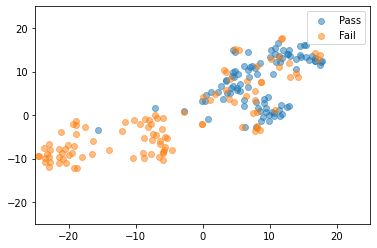

In [2661]:
from sklearn.manifold import TSNE
X_train_embedded = TSNE(n_components=2).fit_transform(np.array(embs))
l1 = np.array(list(set(range(len(g_train))) & set(pass_ix_train)))
l2 = np.array(list(set(range(len(g_train))) & set(fail_ix_train)))
plt.scatter(X_train_embedded[l1,0], X_train_embedded[l1, 1], label='Pass', alpha=0.5)
plt.scatter(X_train_embedded[l2,0], X_train_embedded[l2, 1], label='Fail', alpha=0.5)
plt.legend()
plt.xlim([-25, 25])
plt.ylim([-25, 25])
plt.show()

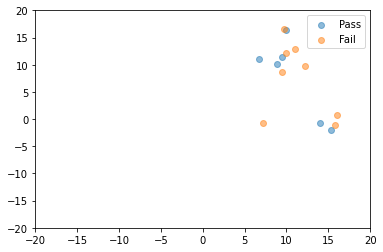

In [2663]:
from sklearn.manifold import TSNE
X_test_embedded = TSNE(n_components=2).fit_transform(np.array(embs))
plt.scatter(X_test_embedded[pass_ix,0], X_test_embedded[pass_ix, 1], label='Pass', alpha=0.5)
plt.scatter(X_test_embedded[fail_ix,0], X_test_embedded[fail_ix, 1], label='Fail', alpha=0.5)
plt.legend()
plt.xlim([-20, 20])
plt.ylim([-20, 20])
plt.show()

In [2664]:
print('RF Pass:', eval_o1[:, 0])
print('Fail:', eval_o1[:, 1])
print('F1:', eval_o1[:, 3])

RF Pass: [0.71428571 0.28571429 0.71428571 0.57142857 0.71428571 0.85714286
 0.42857143 0.42857143 0.85714286 0.85714286 0.5        1.
 0.5        0.66666667 0.83333333]
Fail: [0.75       0.375      0.875      0.875      0.57142857 0.85714286
 0.85714286 0.57142857 0.57142857 0.71428571 0.875      0.5
 0.75       0.625      0.875     ]
F1: [0.75       0.375      0.82352941 0.77777778 0.61538462 0.85714286
 0.70588235 0.53333333 0.66666667 0.76923077 0.77777778 0.66666667
 0.70588235 0.66666667 0.875     ]


In [2665]:
print('O2 Pass:', eval_o2[:, 0])
print('Fail:', eval_o2[:, 1])
print('F1:', eval_o2[:, 3])

O2 Pass: [0.71428571 0.71428571 0.85714286 0.28571429 0.71428571 0.85714286
 0.71428571 0.42857143 0.85714286 0.85714286 0.16666667 0.83333333
 0.5        0.83333333 0.83333333]
Fail: [0.875      0.75       0.875      1.         0.42857143 0.85714286
 0.71428571 0.42857143 0.57142857 0.85714286 1.         0.75
 0.875      0.75       1.        ]
F1: [0.82352941 0.75       0.875      0.76190476 0.5        0.85714286
 0.71428571 0.42857143 0.66666667 0.85714286 0.76190476 0.8
 0.77777778 0.8        0.94117647]


In [2196]:
from sklearn.metrics import f1_score

def to_labels(pos_probs, threshold):
    return (pos_probs >= threshold).astype('int')

min_constraints = 0.5 
thresholds = np.arange(0, 1, 0.001)
probs = classifier.predict(X_train).flatten()
scores = [f1_score(y_train, to_labels(probs, t)) for t in thresholds]
ix = np.argmax(scores)
print('Threshold=%.3f, F-Score=%.5f' % (thresholds[ix], scores[ix]))
print('Pass=%.3f, Fail=%.5f' % (balanced_accuracy_score(y_train[pass_ix_train], to_labels(probs[pass_ix_train], thresholds[ix])), balanced_accuracy_score(y_train[fail_ix_train], to_labels(probs[fail_ix_train], thresholds[ix]))))

Threshold=0.590, F-Score=0.98592
Pass=1.000, Fail=0.97222


In [2197]:
print('Total', len(X_test), thresholds[ix], end='\n\n')
probs = classifier.predict(X_test).flatten()
print('Pass', balanced_accuracy_score(y_test[pass_ix], to_labels(probs, thresholds[ix])[pass_ix]))
print('Fail', balanced_accuracy_score(y_test[fail_ix], to_labels(probs, thresholds[ix])[fail_ix]))
print('Over', balanced_accuracy_score(y_test, to_labels(probs, thresholds[ix])))

Total 21 0.59

Pass 0.7692307692307693
Fail 0.5
Over 0.6346153846153846


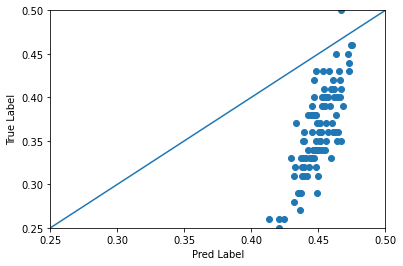

In [1843]:
x1 = []
x2 = []
indexes = np.arange(len(X_train))
for _ in range(100):
    bucket = np.random.choice(indexes, 100)
    x1.append(np.mean(classifier.predict(X_train[bucket]).flatten()))
    x2.append(np.mean(y_train[bucket]))
plt.plot([0,1], [0,1])
plt.scatter(x1, x2)
plt.xlabel('Pred Label')
plt.ylabel('True Label')
plt.xlim([.25, .50])
plt.ylim([.25, .50])
plt.show()

In [1388]:
print('Names', ChenCui().getFeatureNames())
print(X[nuser])

Names ['totalClicks', 'numberSessions', 'totalTimeAllSessions', 'avgSessionTime', 'stdSessionTime', 'totalClicksWeekdays', 'totalClicksWeekends', 'ratioClicksWeekdaysWeekends', 'totalClicksOnProblems', 'totalTimeOnProblems', 'stdTimeOnProblems']
[[3.99000000e+02 1.00000000e+01 4.64770000e+04 4.64770000e+03
  3.69631909e+03 6.00000000e+01 1.12000000e+02 5.35714286e-01
  2.30000000e+02 7.16000000e+02 1.95626553e+01]
 [2.48000000e+02 4.00000000e+00 3.68260000e+04 9.20650000e+03
  6.15895090e+03 1.82000000e+02 5.00000000e+01 3.64000000e+00
  1.24000000e+02 5.83000000e+02 1.98139213e+01]
 [1.47000000e+02 3.00000000e+00 1.35300000e+04 4.51000000e+03
  3.71054075e+03 4.70000000e+01 1.00000000e+02 4.70000000e-01
  6.80000000e+01 6.70000000e+01 3.96715770e+00]
 [2.44000000e+02 3.00000000e+00 1.88130000e+04 6.27100000e+03
  2.45390845e+03 2.18000000e+02 0.00000000e+00 9.81784719e+17
  1.80000000e+02 2.70000000e+02 8.27716984e+00]]


## Model Training and Evaluation

**Points to Consider**

- Basically, the prior work tried all the algorithms included in ScikitLearn. Which algorithms should we use?
    - RandomForest and Lasso for understanding also feature importance. 
    - Check the algorithms which gave the highest accuracy in the prior work. 
    - LSTM (and not Dense) as a deep baseline. 
- How should we combine weekly features for shallow models (for period and for LSTM, there is no problem)? 
    - Average: to get an averaged weekly vector.
    - Vectorization: in this way, we the same feature is duplicated along the feature vector of a student.   
    - None: with random forest, we could ajdust it to receive multivariate time series.
- What should we do with weekly all zero vectors (e.g., no activities in that week)? Should we discard them before training? 

In [378]:
classifier_types = {
    'rf': RandomForestClassifier(),
    'mlp': MLPClassifier(),
    'svm': SVC()
}

In [227]:
classifier_params = {
    'rf': {'n_estimators': [25, 50, 100, 200], 'criterion': ('gini', 'entropy'), 'max_features': ('auto', 'sqrt', 'log2')},
    'mlp': {'activation': ('tanh', 'relu'), 'solver': ('sgd', 'adam'), 'hidden_layer_sizes': [(8,), (16, 8), (32, 16, 8)]},
    'svm': {'C': [1.0, 0.5], 'kernel': ('linear', 'poly', 'rbf', 'sigmoid'), 'gamma': ('scale', 'auto')} 
}

In [228]:
metrics = {
    'acc': balanced_accuracy_score, 
    'f1': f1_score, 
    'p': precision_score, 
    'r': recall_score, 
    'tp': tp, 'fn': fn, 'tn': tn, 'fp': fp, 
    'tpr': tpr, 'tnr': tnr, 'fpr': fpr, 'fnr': fnr
}

In [ ]:
classifiers = {} 
scores = {}

for tmode, cmode in product(params['ftime_mode'], params['concat_mode']):
    setup = tmode + '-' + cmode
        
    classifiers[setup] = {}
    scores[setup] = {}
    
    for coindex, (course, data) in enumerate(event_data.items()):
        classifiers[setup][course] = {}
        scores[setup][course] = {}

        # Prediction data
        X = np.arange(len(data['label']['AccountUserID']))
        y = data['label'][params['target']].values

        skf = StratifiedKFold(n_splits=params['n_splits'], shuffle=True, random_state=0)
        for index, (train_index, test_index) in enumerate(skf.split(X, y)):

            # Data split
            X_train, X_test = X[train_index], X[test_index]
            y_train, y_test = y[train_index], y[test_index]

            # Fold split
            for findex, flabel in enumerate(feature_sets[tmode][course].keys()):
                classifiers[setup][course][flabel] = {}
                if flabel not in scores[setup][course]:
                    scores[setup][course][flabel] = {}

                # Weekly train
                for windex, wid in enumerate(range(14)):
                    classifiers[setup][course][flabel][wid] = {}
                    if wid not in scores[setup][course][flabel]:
                        scores[setup][course][flabel][wid] = {}

                    # Feature scaling
                    if cmode == 'vec':
                        x_train = feature_sets[tmode][course][flabel][X_train, : (wid + 1)].reshape(len(X_train), -1)
                        x_test = feature_sets[tmode][course][flabel][X_test, : (wid + 1)].reshape(len(X_test), -1)
                    else:
                        x_train = np.mean(feature_sets[tmode][course][flabel][X_train, : (wid + 1), :], axis=1)
                        x_test = np.mean(feature_sets[tmode][course][flabel][X_test, : (wid + 1), :], axis=1)

                    scaler = StandardScaler()
                    scaled_x_train = scaler.fit_transform(x_train)
                    scaled_x_test = scaler.transform(x_test)

                    for cindex, (cname, classifier) in enumerate(classifier_types.items()):
                        # Classifier train with grid search
                        grid = classifier_params[cname]
                        classifiers[setup][course][flabel][wid][cname] = GridSearchCV(classifier, grid, cv=10, scoring='f1')
                        classifiers[setup][course][flabel][wid][cname].fit(scaled_x_train, y_train)

                        if cname not in scores[setup][course][flabel][wid]:
                            scores[setup][course][flabel][wid][cname] = {}

                        # Classifier evaluation
                        for mname, mfunc in metrics.items():
                            clf = classifiers[setup][course][flabel][wid][cname]
                            val = mfunc(y_test, np.around(clf.predict(scaled_x_test)))

                            # Metric calculation
                            if mname not in scores[setup][course][flabel][wid][cname]:
                                scores[setup][course][flabel][wid][cname][mname] = []
                            scores[setup][course][flabel][wid][cname][mname].append(val)

                            # Fold metric averaging
                            if (index + 1) == params['n_splits']:
                                fold_average = np.mean(scores[setup][course][flabel][wid][cname][mname])
                                scores[setup][course][flabel][wid][cname][mname] = fold_average

                        print('\rCourse:', 
                              '{:<20}'.format(course[-20:]), 
                              '- ( Fold:', 
                              '{:02d}'.format(index+1), ')', 
                              '( Setup:', 
                              '{:<10}'.format(setup), ')', 
                              '( Set:', '{:<10}'.format(flabel), 
                              '{:02d}'.format(findex + 1), '{:02d}'.format(len(feature_names)), 
                              ') ( Week:', 
                              '{:02d}'.format(wid + 1), '{:02d}'.format(params['max_course_weeks']), ')', 
                              '- ( Clf:', 
                              '{:<3}'.format(cname), ')', 
                              end='')
                        
        print()

## Experimental Results and Discussion

In [ ]:
lst_data = []
lst_name = []
for setup in scores.keys():
    for course in scores[setup].keys():
        for flabel in scores[setup][course].keys():
            for wid in scores[setup][course][flabel].keys():
                for cname in scores[setup][course][flabel][wid].keys():
                    fixed_values = [setup, course, flabel, wid, cname]
                    fixed_names = ['setup', 'course', 'set', 'week', 'classifier']
                    lst_data.append(fixed_values + list(scores[setup][course][flabel][wid][cname].values())) 
                    lst_name = fixed_names + list(scores[setup][course][flabel][wid][cname].keys())

In [ ]:
df = pd.DataFrame(lst_data, columns=lst_name)

In [ ]:
exp_setup = 'week-avg'

### RQ0 What hyperparameter setting leads to the most accurate results for each algorithm?

In [ ]:
dfp = {}
for cname in classifier_types.keys():
    lst_data = []
    lst_name = []
    for course in scores[exp_setup].keys():
        for flabel in scores[exp_setup][course].keys():
            for wid in scores[exp_setup][course][flabel].keys():
                bestparams_vals = classifiers[exp_setup][course][flabel][wid][cname].best_params_.values()
                bestparams_keys = classifiers[exp_setup][course][flabel][wid][cname].best_params_.keys()
                lst_data.append([course, flabel, wid, cname] + list(bestparams_vals)) 
                lst_name = ['course', 'set', 'week', 'classifier'] + list(bestparams_keys)
    dfp[cname] = pd.DataFrame(lst_data, columns=lst_name)

In [ ]:
def plot_model_parameter_over_weeks(df, classifier, parameter):
    plt.figure(figsize=(30, 6), dpi=360)
    plt.title(parameter  + ' of ' + classifier)
    colors = [plt.cm.rainbow(x) for x in np.linspace(0, 1, 8)]
    
    for cindex, course in enumerate(df[classifier]['course'].unique()):    
        df_features = df[classifier][df[classifier]['course'] == course]
        plt.plot(df_features['week'], df_features[parameter], lw=1, color=colors[cindex], label=course)

        plt.xlim([df_features['week'].values[0], df_features['week'].values[-1]])
        plt.ylim([df_features[parameter].min() - 2, df_features[parameter].max() + 2])
        plt.xlabel('Week')
        plt.ylabel(parameter.title())
        plt.grid(axis='y')
        plt.legend(loc='upper right')
        
    plt.show()

In [ ]:
plot_model_parameter_over_weeks(dfp, 'rf', 'n_estimators')

**Points to Consider**
- Use bar plots instead of line splots, otherwise it is hard to understand overlapping lines. 

### RQ1: What feature set is the best for a given algorithm?

In [ ]:
def plot_metrics_per_model(df, metric, classifier):
    plt.figure(figsize=(30, 6 * (len(df['course'].unique()) // 3 + 1)), dpi=360)
    
    colors = [plt.cm.rainbow(x) for x in np.linspace(0, 1, 8)]
    for cindex, course in enumerate(df['course'].unique()):
        plt.subplot(len(df['course'].unique()) // 3 + 1, 2, cindex + 1)
        
        plt.title(classifier + ' in ' + course)
        for findex, flabel in enumerate(df['set'].unique()): 
            df_features = df[(df['course'] == course) & (df['set'] == flabel)]
            df_classifiers = df_features[df_features['classifier'] == classifier]
            plt.plot(df_classifiers['week'], df_classifiers[metric].values, lw=1, color=colors[findex], label=flabel)

        plt.ylim([0.40, 0.80])
        plt.xlim([df_classifiers['week'].values[0], df_classifiers['week'].values[-1]])
        plt.xlabel('Week')
        plt.ylabel(metric)
        plt.grid(axis='y')
        plt.legend(loc='upper left')
        
    plt.show()

In [ ]:
plot_metrics_per_model(df[df['setup'] == exp_setup], 'acc', 'rf')

### RQ2: What classifier is the best for a given feature set?

In [ ]:
def plot_metrics_per_feature(df, metric, feature_name):

    plt.figure(figsize=(30, 6 * (len(df['course'].unique()) // 3 + 1)), dpi=360)
    
    colors = [plt.cm.rainbow(x) for x in np.linspace(0, 1, 8)]
    for cindex, course in enumerate(df['course'].unique()):
        plt.subplot(len(df['course'].unique()) // 3 + 1, 2, cindex + 1)
        
        df_features = df[(df['course'] == course) & (df['set'] == flabel)]

        plt.title(flabel + ' on ' + course)
        for clfindex, classifier in enumerate(df_features['classifier'].unique()): 
            df_clf = df_features[df_features['classifier'] == classifier]
            plt.plot(df_clf['week'], df_clf[metric].values, lw=1, color=colors[clfindex], label=classifier)

        plt.ylim([0.40, 0.75])
        plt.xlim([df_features['week'].values[0], df_features['week'].values[-1]])
        plt.xlabel('Week')
        plt.ylabel(metric)
        plt.grid(axis='y')
        plt.legend(loc='upper left')

In [ ]:
plot_metrics_per_feature(df[df['setup'] == exp_setup], 'acc', 'chen_cui')

### RQ3: How the feature importance distribution changes over weeks?

In [ ]:
def plot_importance_per_feature(classifiers, classifier, feature_name):

    plt.figure(figsize=(30, 6 * (len(classifiers.keys()) // 3 + 1)), dpi=360)
    
    colors = [plt.cm.rainbow(x) for x in np.linspace(0, 1, 8)]
    for cindex, course in enumerate(classifiers.keys()):
        plt.subplot(len(classifiers.keys()) // 3 + 1, 4, cindex + 1)
        
        rkey = classifiers[course][feature_name][list(classifiers[course][feature_name].keys())[0]]
        
        nweeks = len(classifiers[course][feature_name].keys())
        nfeatures = len(rkey[classifier].best_estimator_.feature_importances_)
        
        plt.title(classifier + ' on ' + course)
        importance_mtx = np.zeros((nweeks, nfeatures))
        for windex, wid in enumerate(classifiers[course][feature_name].keys()):
            importance_mtx[windex] = classifiers[course][feature_name][wid][classifier].best_estimator_.feature_importances_
            
        plt.colorbar(plt.imshow(importance_mtx, cmap='hot', interpolation='nearest', vmin=0, vmax=0.2))
        plt.yticks(range(nweeks), ['Week ' + str(wid) for wid in classifiers[course][feature_name].keys()])
        plt.xticks(range(nfeatures), find_ffunc(feature_name).getFeatureNames(), rotation=90)
        
    plt.show()

In [ ]:
plot_importance_per_feature(classifiers[exp_setup], 'rf', 'chen_cui')

**Points to Consider**
- Somehow sort features on the x-axis based on their importance and highlight the different important heatmap regions across courses. 

### RQ4: Which aggregation of feature over time leads to more accurate models?

In [ ]:
def plot_metrics_per_mode(df, metric, classifier, feature_name):
    plt.figure(figsize=(30, 6 * (len(df['course'].unique()) // 3 + 1)), dpi=360)
    
    colors = [plt.cm.rainbow(x) for x in np.linspace(0, 1, 8)]
    for cindex, course in enumerate(df['course'].unique()):
        plt.subplot(len(df['course'].unique()) // 3 + 1, 2, cindex + 1)
        
        plt.title(classifier  + ' on ' + feature_name + ' in ' + course)
        for sindex, slabel in enumerate(df['setup'].unique()): 
            df_features = df[(df['course'] == course) & (df['set'] == feature_name) & (df['setup'] == slabel)]
            df_classifiers = df_features[df_features['classifier'] == classifier]
            plt.plot(df_classifiers['week'], df_classifiers[metric].values, lw=1, color=colors[sindex], label=slabel)

        plt.ylim([0.40, 0.80])
        plt.xlim([df_classifiers['week'].values[0], df_classifiers['week'].values[-1]])
        plt.xlabel('Week')
        plt.ylabel(metric)
        plt.grid(axis='y')
        plt.legend(loc='upper left')
        
    plt.show()

In [ ]:
plot_metrics_per_mode(df, 'acc', 'rf', 'chen_cui')

**Points to Consider**

- Analyze the probabilities returned by the classifier.
- Build models in such a way that they consider what they predict in the previous week, with a decay parameter. 